# simplier version of Pytorch Dataloader Inference (Swin transformer)

In [1]:
#  not used !pip install git+file:///kaggle/input/effnetpytorch/EfficientUnet-PyTorch

In [2]:
import tifffile
from glob import glob
import cv2 as cv
import os
import sys

In [3]:
sys.path.append('../input/shadik-swinv1-upernet-code')

In [4]:
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Tuple

import numpy as np
import pandas as pd


import seaborn as sns
import tifffile
import random

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import albumentations as A
import albumentations.pytorch

In [6]:
TEST_CSV = './../input/hubmap-organ-segmentation/test.csv'
TEST_IMAGES_DIR = './../input/hubmap-organ-segmentation/test_images/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022
CURRENT_FOLD = 0

SPATIAL_SIZE = 768 # размер патча
BATCH_SIZE = 2
# TEST_IMAGES_DIR = './../data/test_images/' # one image - not in use

In [7]:
def make_train_image_path(row):
    return os.path.join(TEST_IMAGES_DIR, str(row['id']) + '.tiff')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [8]:
test_df = pd.read_csv(TEST_CSV)
test_df['image'] = test_df.apply(make_train_image_path, axis=1)

In [9]:
train_transform = A.Compose([
    A.Resize(SPATIAL_SIZE, SPATIAL_SIZE, interpolation = cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HueSaturationValue(p=0.7),
    A.ShiftScaleRotate(shift_limit = 0.02, scale_limit=(0.1, 0.6),rotate_limit = 90,p = 0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, 
      alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

val_transform = A.Compose([
    A.Resize(SPATIAL_SIZE, SPATIAL_SIZE, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)


test_transform = A.Compose([
    A.Resize(SPATIAL_SIZE, SPATIAL_SIZE, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [10]:
class HubmapTestDataset(Dataset):   
    def __init__(self, df, transform):
    
        print('-' * 40)
        print('hubmap simple dataset (Total {} samples)'.format(len(df)))
        print('-' * 40)
        
        self.df = df
        self.transform = transform
        

    def __len__(self):
        return len(self.df) # * self.runtime_frame_repeats

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = tifffile.imread(row['image'])
        
        orig_shape = img.shape[:2]
        
#         img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        
        data = self.transform(image=img)
        
        data.update({
            'original_shape_0': orig_shape[0],
            'original_shape_1': orig_shape[1],
            'id': row['id']
        })
        
        return data

In [11]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [12]:
test_dataset = HubmapTestDataset(test_df, test_transform)

----------------------------------------
hubmap simple dataset (Total 1 samples)
----------------------------------------


IMAGE
torch.Size([3, 768, 768])
image values:  0.0 1.0


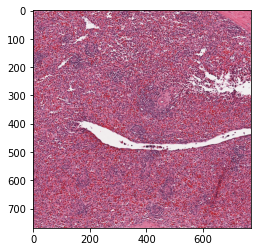

In [13]:
sample = test_dataset[0]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

In [14]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_test = DataLoader(test_dataset, batch_size = 1, **loader_params)

In [15]:
device = 'cuda'

In [16]:
cfg = dict(
        output_type=['inference'],
        #configs/_base_/models/upernet_swin.py
        basic = dict(
            swin=dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.3,
                ape=False,
                patch_norm=True,
                out_indices=(0, 1, 2, 3),
                use_checkpoint=False
            ),

        ),

        #configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py
        swin_tiny_patch4_window7_224=dict(
            checkpoint = None, #pretrain_dir+'/swin_tiny_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False,
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),

        #/configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k.py
        swin_small_patch4_window7_224_22k=dict(
            checkpoint = None, #pretrain_dir+'/swin_small_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 18, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),
    )

In [17]:
from swintransformer import Net

In [18]:
models = [Net(cfg).to(device) for _ in range(5)]
for i, bname in enumerate(['fold0_00010080', 'fold1_00010080', 'fold2_00010080', 'fold3_00010080', 'fold4_00010080']):
    fname = f'../input/shadikswinv1upernernoftcheckpoints10080/{bname}.model.pth'
    f = torch.load(fname, map_location=torch.device(device))
    models[i].load_state_dict(f['state_dict'])
    

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
for i in range(len(models)):
    models[i].eval()

In [20]:
def mask2rle(img):
    '''
    Efficient implementation of mask2rle, from @paulorzp
    --
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
    '''
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


@torch.no_grad()
def create_pred_df(models, dataloader):
    THRESHOLD = 0.5
    ids = []
    rles = []
    for batch in tqdm(dataloader):
        with torch.no_grad():
            outputs_folded = []
            for i in range(len(models)):
    #         print(batch['image'].shape)
                id_ = batch["id"].numpy()[0]
                height = batch["original_shape_0"].numpy()[0]
                width  = batch["original_shape_1"].numpy()[0]

                batch["image"] = batch["image"].to(device)
        #         outputs = model(batch)[0]
                outputs = models[i](batch)
        
        
#         outputs = (torch.sigmoid(outputs).detach().cpu().numpy() > THRESHOLD).astype(np.uint8)[0]
                outputs = outputs['probability'][0].detach().cpu().numpy()[0]
                outputs_folded.append(outputs)
            conct = np.array(outputs_folded)
#             print(conct.shape)
            
            outputs_folded = (conct.mean(axis=0) > THRESHOLD).astype(np.uint8)
#             print(outputs_folded.shape)
        
#         print(outputs.shape, height, width)
        mask = cv.resize(outputs_folded, (width, height), interpolation=cv.INTER_NEAREST)
    
        
#         plt.imshow(mask)
#         plt.show()

#         plt.imshow(images[0].permute((1, 2, 0)).detach().cpu().numpy())
#         plt.show()
        
        rle = mask2rle(mask)
        
        ids.append(id_)
        rles.append(rle)
        
    return pd.DataFrame({"id": ids, "rle": rles})

In [21]:
test_pred_df = create_pred_df(models, loader_test)

100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


In [22]:
test_pred_df.to_csv("submission.csv", index=False)
test_pred_df


,id,rle
0,10078,1509742 5 1509781 8 1511765 5 1511804 8 151378...
